In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [3]:
train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [4]:
#check for null values
train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [5]:
#check for duplicated values
train.duplicated().sum()

0

In [6]:
train['Transported'].value_counts()
#the dataset is balanced

Transported
True     4378
False    4315
Name: count, dtype: int64

In [7]:
train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

### EDA

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

TARGET VARIABLE ANALYSIS

Text(0.5, 1.0, 'Number of Transported people')

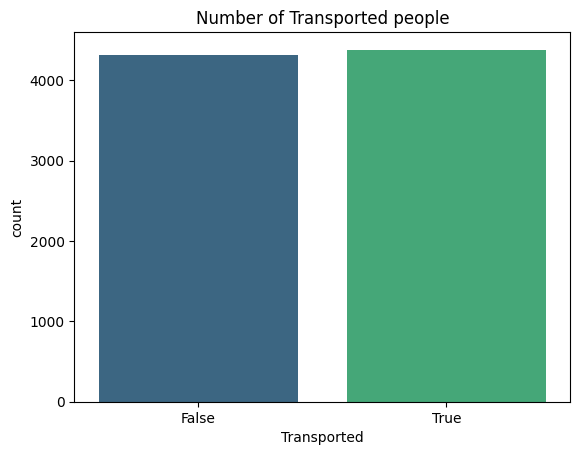

In [9]:
sns.barplot(x=train['Transported'].value_counts().index, y =train['Transported'].value_counts(),palette="viridis")
plt.title('Number of Transported people')

The dataset is balanced, so we dont need to use over sampling/under sampling techniques and we can use accuracy as our metric

NUMERICAL VARIABLES ANALYSIS

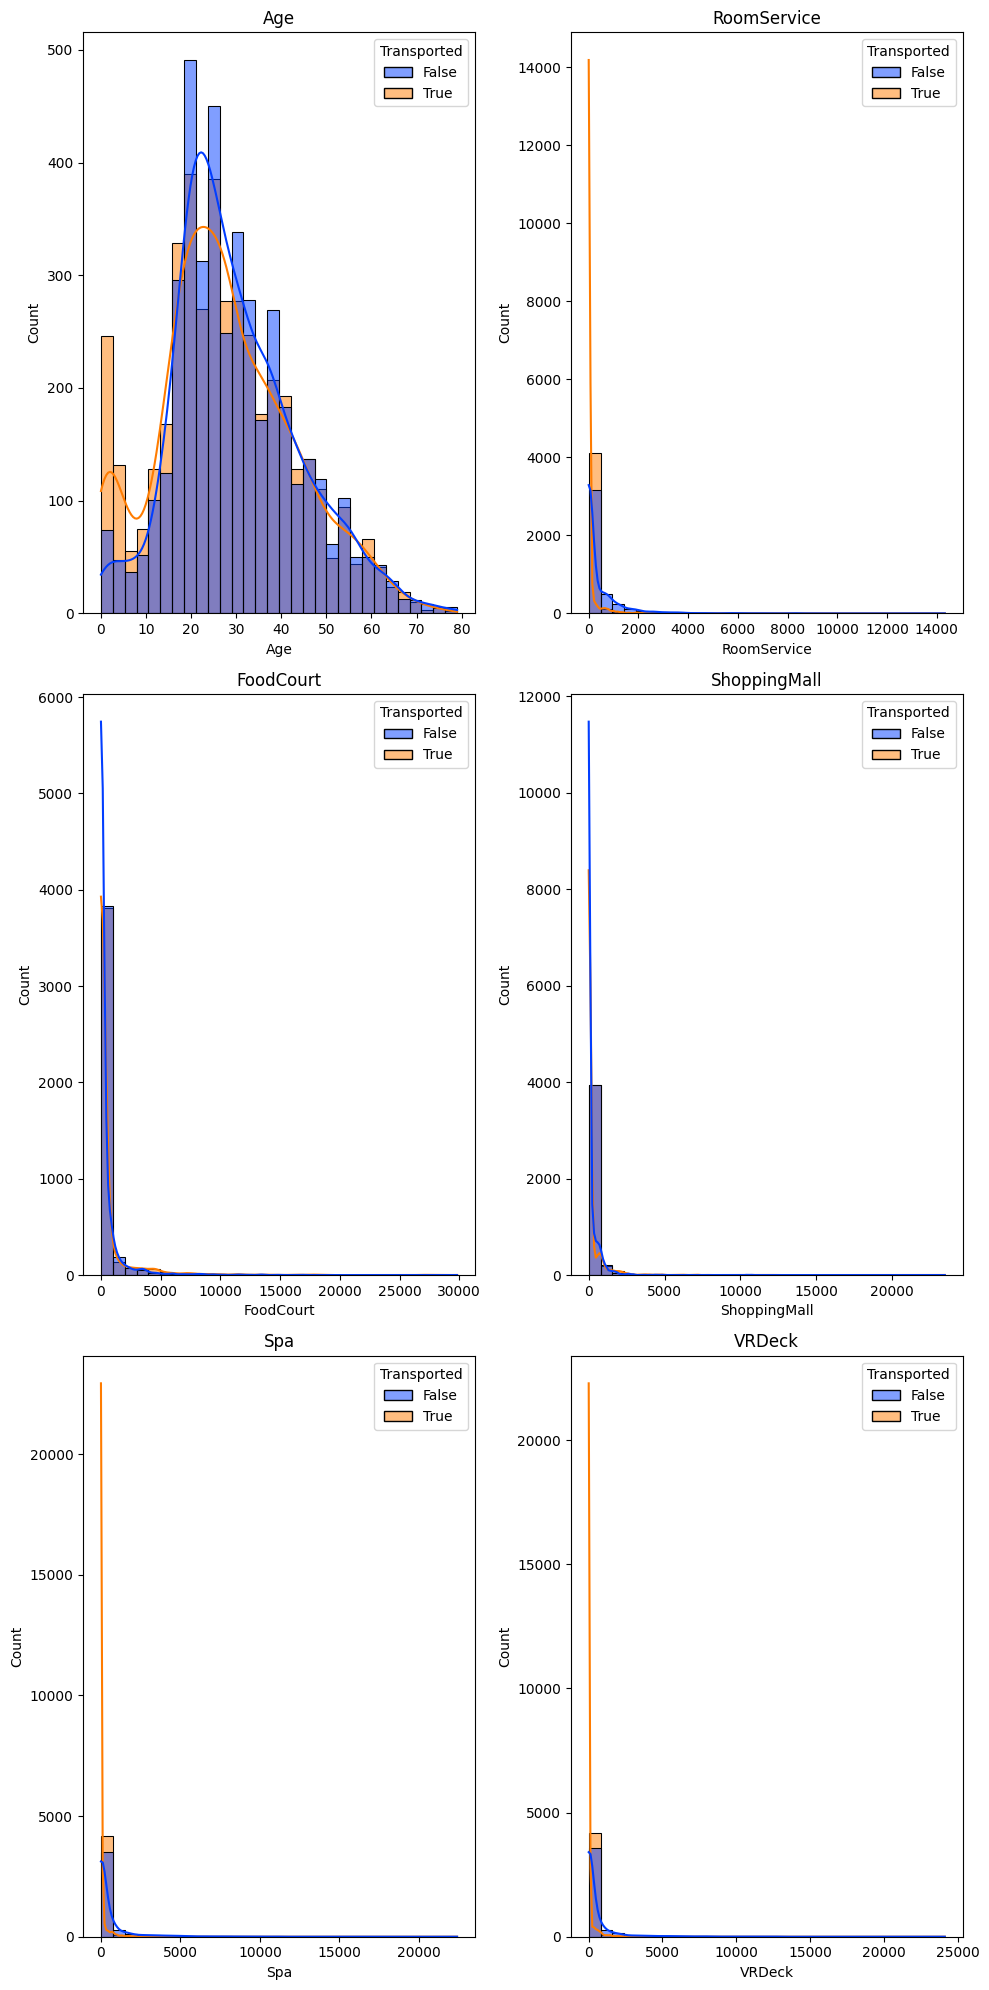

In [10]:
num_features = ['Age','RoomService','FoodCourt','ShoppingMall', 'Spa','VRDeck']
fig=plt.figure(figsize=(10,20))

for i, feat in enumerate(num_features):
    ax=fig.add_subplot(3,2,i+1)
    sns.histplot(x=train[feat], hue = train['Transported'],palette="bright",bins=30,kde=True)
    plt.title(feat)

plt.tight_layout()
plt.show()

From these distributions, we can see that they are skewed and have outliers! So, using these features would hinder the performance of the model. Hence we have to consider: 1. creating bins 2. use models which are robuust to outliers

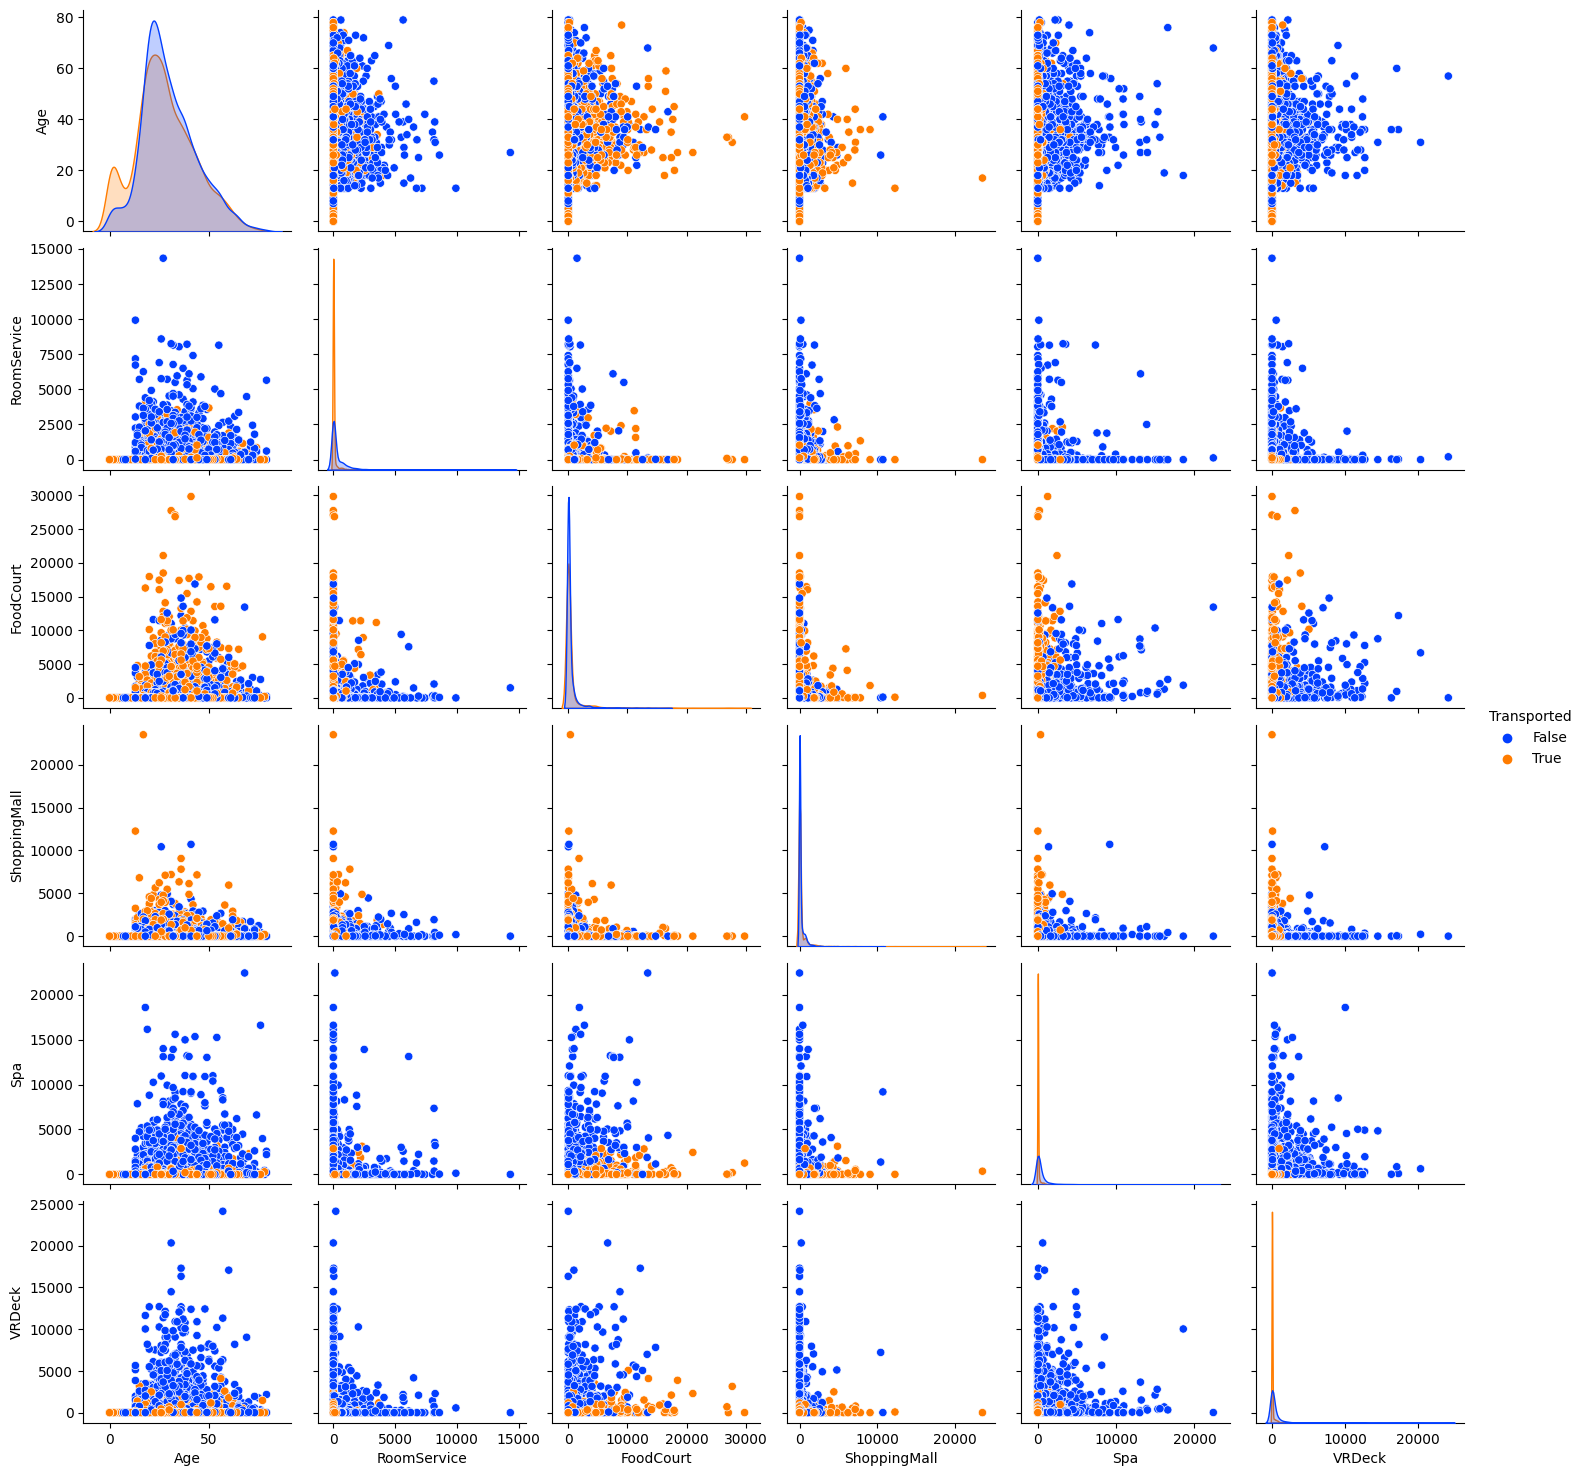

In [11]:
sns.pairplot(train[num_features + ['Transported']], hue='Transported', palette='bright')

# Show the plot
plt.show()

From this pairplot, we are seeing if the variables can clearly distinguish between the 2 classes present. So, here we can see that the variables Spa, RoomService and VR Deck have a good differentiation b/w classes

We will use a t test to confirm this. H0: variable can't differentiate the 2 classes. H1: variable can differentiate the 2 classes

In [12]:
from prettytable import PrettyTable
from scipy import stats
import statsmodels.api as sm
from scipy.stats import ttest_ind

In [13]:
def perform_ttest(df, features, target):
    ttest_results = {}
    table = PrettyTable()

    table.field_names = ['Feature', 't_stat', 'p_val']
    for feature in features:
        group_0 = train[train[target]==0][feature]
        group_1 = train[train[target] == 1][feature]
        
        t_stat, p_val = ttest_ind(group_0, group_1, nan_policy='omit')
        table.add_row([feature,t_stat, p_val ])
    return print(table)

In [14]:
perform_ttest(train, num_features, 'Transported')

+--------------+--------------------+------------------------+
|   Feature    |       t_stat       |         p_val          |
+--------------+--------------------+------------------------+
|     Age      | 6.941461666045089  | 4.165050977554494e-12  |
| RoomService  | 23.27230572812196  | 3.400493892669515e-116 |
|  FoodCourt   | -4.299893771259008 | 1.727865340729664e-05  |
| ShoppingMall | -0.934056481671101 |   0.3503013444989256   |
|     Spa      | 20.914657362229097 | 9.275825095363414e-95  |
|    VRDeck    | 19.517825470012635 | 4.9897017399892476e-83 |
+--------------+--------------------+------------------------+


If the p value is less than 0.05 we reject the null hypothesis, otherwise we accept the null hypothesis. as, we can see that the variable shoppingmall has p value > 0.05 which means that the group of means are not significantly different.

CATEGORICAL VARIABLE ANALYSIS/


In [15]:
train.groupby(['HomePlanet', 'Transported']).size().reset_index(name='counts')

,HomePlanet,Transported,counts
0,Earth,False,2651
1,Earth,True,1951
2,Europa,False,727
3,Europa,True,1404
4,Mars,False,839
5,Mars,True,920


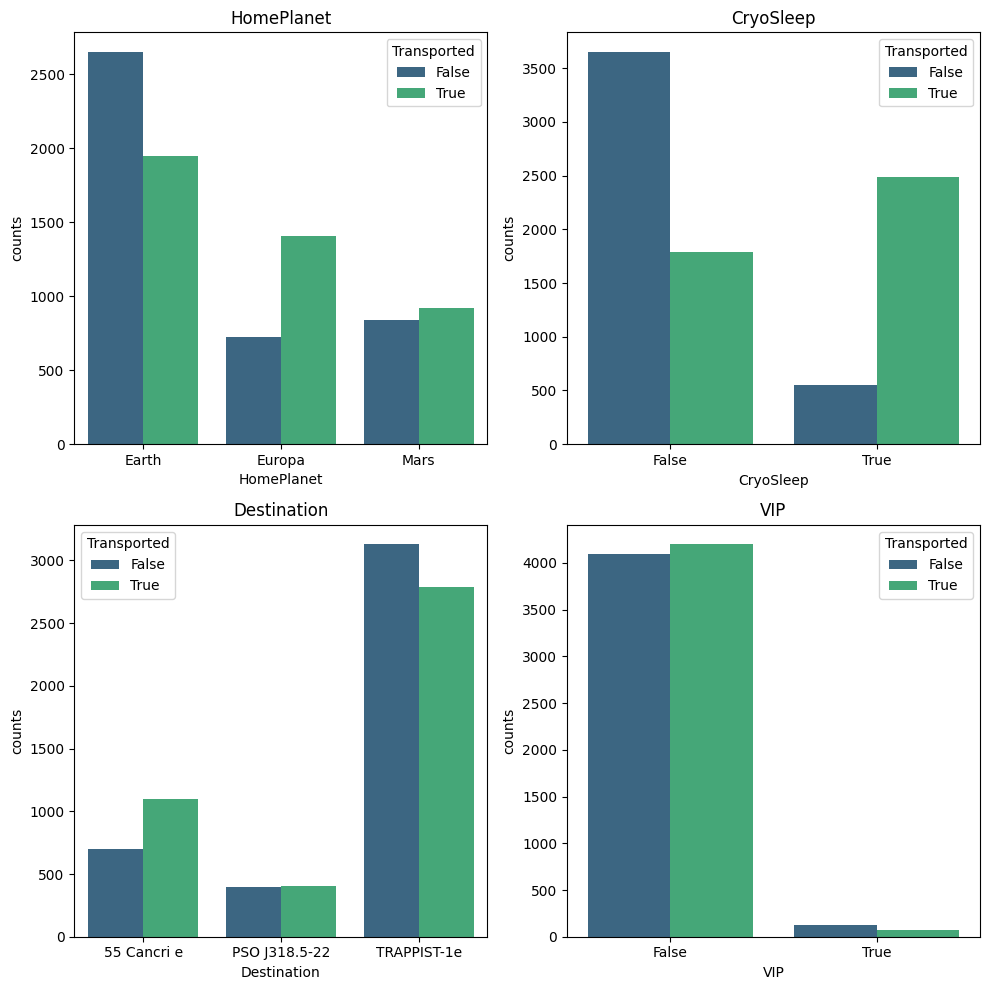

In [16]:
cat_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
fig=plt.figure(figsize=(10,10))

for i, feat in enumerate(cat_features):
    ax=fig.add_subplot(2,2,i+1)
    counts = train.groupby([feat, 'Transported']).size().reset_index(name='counts')
    sns.barplot(x=feat, y='counts', hue ='Transported', data = counts, palette="viridis")
    plt.title(feat)

plt.tight_layout()
plt.show()

1. People who were on cryosleep transported more.
2. people who are not VIP were transported most.

### Data Cleaning

If the data type of the column is integer, we can fill it with median, otherwise we fill it with mode.

In [17]:
train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [18]:
#Removing NA's
def remove_na(df):
    for col in df.columns:
        if df[col].dtype == object:
            df[col].fillna(df[col].mode()[0],inplace = True)
        if df[col].dtype== float:
            df[col].fillna(df[col].median(),inplace = True)
    return df

In [19]:
train = remove_na(train)
train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [20]:
train.isna().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64

### Feature Engineering

In [21]:
df = train.copy()

In [22]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [23]:
def feature_eng(df):
    #Summing up all the expenses
    df['all_expenses'] = df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck']
    #Expanding the cabin column
    df[['Deck','Num','Side']] = df['Cabin'].str.split('/',expand = True)
    df['Num'] = df['Num'].astype(int)
    df.drop(['PassengerId','RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','Cabin','Name'], axis =1, inplace = True)
    
    #Applying label encoding
    le = LabelEncoder()
    col_to_encode = ['HomePlanet', 'CryoSleep', 'Deck', 'Side','Destination','VIP','Transported']
    df[col_to_encode] = df[col_to_encode].apply(lambda col: le.fit_transform(col))
    return df

In [ ]:
def standardization(df):
    

In [24]:
df = feature_eng(df)
df

,HomePlanet,CryoSleep,Destination,Age,VIP,Transported,all_expenses,Deck,Num,Side
0,1,0,2,39.0,0,0,0.0,1,0,0
1,0,0,2,24.0,0,1,736.0,5,0,1
2,1,0,2,58.0,1,0,10383.0,0,0,1
3,1,0,2,33.0,0,0,5176.0,0,0,1
4,0,0,2,16.0,0,1,1091.0,5,1,1
...,...,...,...,...,...,...,...,...,...,...
8688,1,0,0,41.0,1,0,8536.0,0,98,0
8689,0,1,1,18.0,0,0,0.0,6,1499,1
8690,0,0,2,26.0,0,1,1873.0,6,1500,1
8691,1,0,0,32.0,0,0,4637.0,4,608,1


In [25]:
df.dtypes

HomePlanet        int64
CryoSleep         int64
Destination       int64
Age             float64
VIP               int64
Transported       int64
all_expenses    float64
Deck              int64
Num               int64
Side              int64
dtype: object

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
X = df.drop(['Transported'],axis=1)
X

,HomePlanet,CryoSleep,Destination,Age,VIP,all_expenses,Deck,Num,Side
0,1,0,2,39.0,0,0.0,1,0,0
1,0,0,2,24.0,0,736.0,5,0,1
2,1,0,2,58.0,1,10383.0,0,0,1
3,1,0,2,33.0,0,5176.0,0,0,1
4,0,0,2,16.0,0,1091.0,5,1,1
...,...,...,...,...,...,...,...,...,...
8688,1,0,0,41.0,1,8536.0,0,98,0
8689,0,1,1,18.0,0,0.0,6,1499,1
8690,0,0,2,26.0,0,1873.0,6,1500,1
8691,1,0,0,32.0,0,4637.0,4,608,1


In [28]:
y = df['Transported']
y

0       0
1       1
2       0
3       0
4       1
       ..
8688    0
8689    0
8690    1
8691    0
8692    1
Name: Transported, Length: 8693, dtype: int64

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

In [30]:
X_train,X_val,y_train,y_val = train_test_split(X, y, test_size=0.33, random_state=42)

In [31]:
def train_and_eval(model,model_name):
    model.fit(X_train,y_train)
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    print("Train_accuracy_score:", accuracy_score(y_train,y_train_pred))
    print("Val_accuracy_score:",accuracy_score(y_val,y_val_pred))
    print("Classification Report:")
    print(classification_report(y_val, y_val_pred))
    print("\n")
    

In [32]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
train_and_eval(rf_model, "Random Forest")

Train_accuracy_score: 0.9994848901098901
Val_accuracy_score: 0.7413733008016731
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.81      0.76      1424
           1       0.78      0.68      0.72      1445

    accuracy                           0.74      2869
   macro avg       0.75      0.74      0.74      2869
weighted avg       0.75      0.74      0.74      2869





In [33]:
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)
train_and_eval(xgb_model, "XGBoost")

Train_accuracy_score: 0.9089972527472527
Val_accuracy_score: 0.7347507842453816
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.77      0.74      1424
           1       0.75      0.70      0.73      1445

    accuracy                           0.73      2869
   macro avg       0.74      0.73      0.73      2869
weighted avg       0.74      0.73      0.73      2869





In [34]:
lgb_model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
train_and_eval(lgb_model, "LightGBM")

[LightGBM] [Info] Number of positive: 2933, number of negative: 2891
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 608
[LightGBM] [Info] Number of data points in the train set: 5824, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503606 -> initscore=0.014423
[LightGBM] [Info] Start training from score 0.014423
Train_accuracy_score: 0.8416895604395604
Val_accuracy_score: 0.7535726734053677
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.82      0.77      1424
           1       0.80      0.69      0.74      1445

    accuracy                           0.75      2869
   macro avg       0.76      0.75      0.75      2869
weighted avg       0.76      0.75      0.75      2869





In [36]:
cb_model = cb.CatBoostClassifier(iterations=100, learning_rate=0.1, random_state=42, verbose=0)
train_and_eval(cb_model, "CatBoost")

Train_accuracy_score: 0.7760989010989011
Val_accuracy_score: 0.7525270128964796
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.80      0.76      1424
           1       0.78      0.70      0.74      1445

    accuracy                           0.75      2869
   macro avg       0.76      0.75      0.75      2869
weighted avg       0.76      0.75      0.75      2869





In [38]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=42)
train_and_eval(lr, "lr")

Train_accuracy_score: 0.714114010989011
Val_accuracy_score: 0.7082607180202161
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.77      0.72      1424
           1       0.74      0.65      0.69      1445

    accuracy                           0.71      2869
   macro avg       0.71      0.71      0.71      2869
weighted avg       0.71      0.71      0.71      2869





TEST DATA

In [39]:
test  = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
test

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


In [40]:
test.isna().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

In [41]:
test = remove_na(test)
test

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,9269_01,Earth,False,G/160/P,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,26.0,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,9273_01,Europa,False,D/297/P,TRAPPIST-1e,26.0,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


In [44]:
def feature_eng(df):
    #Summing up all the expenses
    df['all_expenses'] = df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck']
    #Expanding the cabin column
    df[['Deck','Num','Side']] = df['Cabin'].str.split('/',expand = True)
    df['Num'] = df['Num'].astype(int)
    df.drop(['PassengerId','RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','Cabin','Name'], axis =1, inplace = True)
    
    #Applying label encoding
    le = LabelEncoder()
    col_to_encode = ['HomePlanet', 'CryoSleep', 'Deck', 'Side','Destination','VIP']
    df[col_to_encode] = df[col_to_encode].apply(lambda col: le.fit_transform(col))
    return df

In [45]:
X_1 = test.copy()

In [46]:
X_1 = feature_eng(X_1)

In [47]:
X_1

,HomePlanet,CryoSleep,Destination,Age,VIP,all_expenses,Deck,Num,Side
0,0,1,2,27.0,0,0.0,6,3,1
1,0,0,2,19.0,0,2832.0,5,4,1
2,1,1,0,31.0,0,0.0,2,0,1
3,1,0,2,38.0,0,7418.0,2,1,1
4,0,0,2,20.0,0,645.0,5,5,1
...,...,...,...,...,...,...,...,...,...
4272,0,1,2,34.0,0,0.0,6,1496,1
4273,0,0,2,42.0,0,1018.0,6,160,0
4274,2,1,0,26.0,0,0.0,3,296,0
4275,1,0,2,26.0,0,3203.0,3,297,0


In [48]:
pred = lgb_model.predict(X_1)
pred

array([1, 0, 1, ..., 1, 0, 1])

In [49]:
submission = pd.DataFrame({'PassengerId': test.PassengerId, "Transported": pred})
submission

,PassengerId,Transported
0,0013_01,1
1,0018_01,0
2,0019_01,1
3,0021_01,0
4,0023_01,0
...,...,...
4272,9266_02,1
4273,9269_01,0
4274,9271_01,1
4275,9273_01,0


In [50]:
submission['Transported'] = submission['Transported'].map({1:'True',0:'False'})
submission

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,False
4,0023_01,False
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,False


In [51]:
submission.to_csv('submission.csv', index = False)